# Situation Report: 29th October 2024
I have a meeting with my supervisor tomorrow, the first one since starting work on this project. As a result, a lot of things have happened; it is sensible, I think, to go through everything I've done so far and explain my reasoning for each step, to ensure it is well-organised in my mind before I speak to her about it. I will also go through what problems I currently face, and a rough roadmap for where I see this project going. Note: I have decided to write this in a Jupyter notebook, as it allows me to more explicitly talk through what code I have done.

In [18]:
from qiskit import QuantumCircuit
from lambeq import BobcatParser, RemoveCupsRewriter, AtomicType, IQPAnsatz
from pytket.extensions.qiskit import tk_to_qiskit

## Progress Up To This Point
My progress up to this point can be broken up into a series of bullet points, all of which will be explained fully in their own sections. So far I have:

- Created a very simple swap test circuit for fidelity evaluation and tested it briefly.
- Trained a Lambeq model using the `mc_train` and `mc_dev` data found in the [lambeq docs](https://github.com/CQCL/lambeq-docs/tree/main/docs/examples/datasets) and evaluated its accuracy using the `mc_test` data found in the same location.
- Written a function to parse a sentence through the trained model and extract the resulting quantum circuit.
- Written a function which composes the quantum circuits of two sentences and adds a swap test circuit to test the fidelity between the sentence qubits.
- Written a function to rank the similarity of sentences using both my lambeq model and a pre-tested BERT model.
- Implemented a vague arbitrary NDCG calculation to quantifiably evaluate the rankings of my model against the rankings of the BERT model.

### Simple Swap Test

Consider two states, $|\psi\rangle$ and $\phi\rangle$. Conceptually the simplest measurement fidelity is the absolute square of the contraction of these two states:

$\begin{equation}
\textrm{Fidelity} = |\langle \phi|\psi\rangle|^2
\end{equation}$

As outlined by [Basheer, Afham and Goyal](https://arxiv.org/pdf/2003.09187) in 2021, a simple swap test can be used to determine the fidelity between two qubit states. The swap test is shown below - qubits 1 and 2 have the states you wish to compare, and qubit 0 acts as a 'control' qubit which is measured to obtain the fidelity measurement.

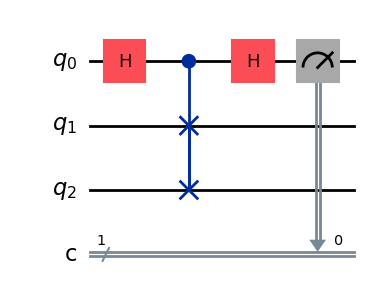

In [3]:
swap_circ = QuantumCircuit(3, 1)

swap_circ.h(0)
swap_circ.cswap(0, 1, 2)
swap_circ.h(0)
swap_circ.measure(0, 0)
swap_circ.draw('mpl')

The control qubit is initially placed in the state $|0\rangle$. Let us assume that qubit 1 is prepared in the state $|\psi\rangle$ and that qubit 2 is prepared in the state $|\phi\rangle$, as shown in the circuit diagram above. Thus the initial state of the circuit is $|\Psi\rangle = |0\psi \phi\rangle$. After the Hadamard on the control qubit this state becomes $\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)|\psi \phi\rangle$. Then after the controlled-swap gate the state becomes $\frac{1}{\sqrt{2}}(|0 \psi \phi\rangle) + |1\phi\psi\rangle)$. The second Hadamard gives us the final state of the quantum circuit:
$\begin{equation}
    \frac{1}{2}(|0 \psi \phi\rangle+|1 \psi \phi\rangle+|0 \phi \psi\rangle-|1 \phi \psi\rangle)
\end{equation}$

We can see that when measuring the control qubit, the outcomes of the measurement are as follows:
$\begin{align}
    \textrm{Prob}(0) &= \frac{1}{4}(\langle \psi \phi| +  \langle\phi\psi|)(|\psi \phi\rangle + |\phi\psi\rangle) = \frac{1}{2} + \frac{1}{2}|\langle \psi | \phi \rangle|^2\\
    \textrm{Prob}(1) &= \frac{1}{4}(\langle \psi \phi| - \langle\phi\psi|)(|\psi \phi\rangle - |\phi\psi\rangle) = \frac{1}{2} - \frac{1}{2}|\langle \psi | \phi \rangle|^2
\end{align}$
Thus we can see that the fidelity will be given by the following:
$\begin{equation}
    \textrm{Fidelity} = |\langle \psi | \phi \rangle|^2 = \textrm{Prob}(0) - \textrm{Prob}(1)
\end{equation}$

Thus we can run the swap test circuit many times to statistically estimate the probabilities of measuring 0 and 1, and use these to find the fidelity between the two states.

### Training a Lambeq Model

In the Lambeq quantum pipeline, sentences are first turned into DisCoCat diagrams using a parser called BobCat. These sentences are then converted into **paramaterised quantum circuits** (PQCs). This involves mapping the DisCoCat diagrams to an *ansatz* quantum circuit. So far, I have chosen the Instantaneous Quantum Polynomial (IQP) ansatz, as this is the ansatz used in the [lambeq documentation and tutorials](https://docs.quantinuum.com/lambeq/). An example ansatz for the sentence **"I love UCl."** is shown below.

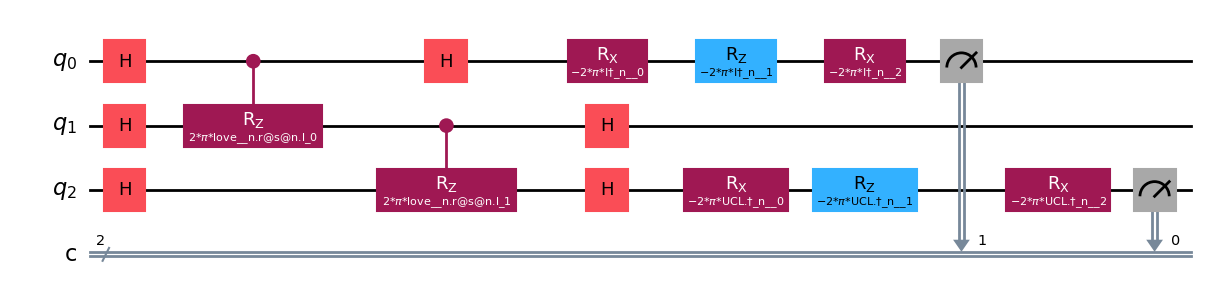

In [23]:
sentence = "I love UCL."
# Convert to DisCoCat diagram
parser = BobcatParser()
discocat_diagram = parser.sentence2diagram(sentence)
# Convert to PQC
remove_cups = RemoveCupsRewriter()
discocat_cupless = remove_cups(discocat_diagram)
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1}, n_layers=1, n_single_qubit_params=3)
PQC = ansatz(discocat_cupless)
# Draw
tk_to_qiskit(PQC.to_tk()).draw('mpl')

Quantum machine learning is used to optimize the parameters for the gates of each word in the vocabulary of the machine learning model. The untrained model is given a list of training sentences along with labels, which are essentially the desired outcomes of the measurement of the sentence qubit (which in the diagram above is qubit $q_1$). Lambeq uses the SPSA algorithm to optimize the parameters of the gates, with a variety of loss functions being available. Up to this point I have been working with data from a binary classification task, and so the loss function I used to train my model was the binary cross-entropy loss.

Once the training data has been fed into the model, it is simply a case of waiting for the training to finish. I made a [training notebook](../testing/training_new_model.ipynb) which outlines how to use lambeq for model training, and visualizes each step in greater detail.

Once the model has been trained, it can be tested, which is also shown in [a notebook](../testing/testing_model.ipynb). The accuracy of the model can be determined by measuring the sentence qubit at the output of each circuit, and comparing this to the desired output.

## Current Challenges

## Roadmap For The Future

Once I have finetuned my approach